## LDA 降维算法
- LDA降维一般分为5个步骤：
> 1. 计算数据集中每个类别的均值向量；  
> 2. 通过均值向量，计算类间散度矩阵$S_B$和类内散度矩阵$S_W$;  
> 3. 对$S_W^{-1}S_BW=\lambda W$进行特征值求解，求出$S_W^{-1}S_B$的特征向量和特征值；  
> 4. 对特征向量按照特征值的大小降序排列，并选择前K个特征向量组成投影矩阵W；  
> 5. 通过$D\times K$ 维的特征值将样本点投影到新的子空间中，$Y = X\times W$

### 1. 二分类下的LDA
**编程实现线性判别，并给出西瓜数据集3.0$\alpha$上的结果。**

In [1]:
import numpy as np 


# 输入西瓜数据集
watermelon= np.array([[0.697,0.460,'是'],[0.774,0.376,'是'],[0.634,0.264,'是'],
           [0.608,0.318,'是'],[0.556,0.215,'是'],[0.403,0.237,'是'],
           [0.481,0.149,'是'],[0.437,0.211,'是'],[0.666,0.091,'否'],
           [0.243,0.267,'否'],[0.245,0.057,'否'],[0.343,0.099,'否'],
           [0.639,0.161,'否'],[0.657,0.198,'否'],[0.360,0.370,'否'],
           [0.593,0.042,'否'],[0.719,0.103,'否']])

# 数据处理-提取特征和类别
features = watermelon[:,0:2].astype('float')
labels = watermelon[:,-1]

### 1.1 用sklearn 实现LDA

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.5,random_state=0 )

clf = LinearDiscriminantAnalysis()
clf.fit(X_train, y_train)
pred_test = clf.predict(X_test)
score = accuracy_score(y_test, pred_test)


print(score)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

0.666666666667
[[3 2]
 [1 3]]
             precision    recall  f1-score   support

          否       0.75      0.60      0.67         5
          是       0.60      0.75      0.67         4

avg / total       0.68      0.67      0.67         9



### 1.2 手动编程实现LDA

In [3]:
# 计算类均值
def class_mean(features_raw, labels_raw):
    mean_vectors = []
    for i in np.unique(labels_raw):
        mean_vectors.append(np.mean(features_raw[labels_raw==i],axis = 0))
    return mean_vectors

# 计算类内散度
def within_scatter(features_raw, labels_raw):
    m = features_raw.shape[1]
    mean_vector = class_mean(features_raw, labels_raw)
    S_w = np.zeros((m,m))
    for i, mean in zip(np.unique(labels),mean_vector):
        mean = np.mat(mean).T
        feature = features_raw[labels_raw==i]
        S_w +=np.dot(feature.T - np.tile(mean,len(feature)),feature - np.tile(mean,len(feature)).T)
    return S_w


def lda_2_class_project_mean(features_raw, labels_raw):
    Sw = within_scatter(features_raw, labels_raw)
    U, sigma, VT = np.linalg.svd(np.mat(Sw))
    Sw_inv = VT.T*np.linalg.inv(np.diag(sigma))*U.T
    mean_vector = class_mean(features_raw, labels_raw)
    w = np.dot(Sw_inv,np.mat(mean_vector[0]-mean_vector[1]).T)
    mean_new = np.zeros((2,1))
    mean_new[0] = np.dot(w.T,np.mat(mean_vector[0]).T)
    mean_new[1] = np.dot(w.T,np.mat(mean_vector[1]).T)

    return w, mean_new

def lda_test(features_raw, labels_raw,features_test, labels_test):
    w, mean_new = lda_2_class_project_mean(features_raw, labels_raw)
    correct = 0
    labels_pred = []
    for i in range(len(features_test)):
        proj = np.dot(w.T,features_test[i])
        if abs(proj - mean_new[0]) <= abs(proj - mean_new[1]):
            pred = np.unique(labels_raw)[0]
            labels_pred.append(np.unique(labels_raw)[0])  
        else:
            pred = np.unique(labels_raw)[1]
            labels_pred.append(np.unique(labels_raw)[1])
        if pred == labels_test[i]:
            correct += 1
    accuracy = correct /len(features_test)
    return accuracy,labels_pred

# 利用上面sklearn拆分的数据集进行计算
acc, y_pred = lda_test(X_train, y_train,X_test, y_test)

print ('accuracy is:',acc )
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

accuracy is: 0.6666666666666666
[[3 2]
 [1 3]]
             precision    recall  f1-score   support

          否       0.75      0.60      0.67         5
          是       0.60      0.75      0.67         4

avg / total       0.68      0.67      0.67         9



### 2.多分类下的LDA  
这里我们使用Iris数据集。程序参考http://sebastianraschka.com/Articles/2014_python_lda.html

In [4]:
feature_dict = {i:label for i,label in zip(range(4),
                                                ('sepal length in cm',
                                                'sepal width in cm',
                                                'petal length in cm',
                                                'petal width in cm',))}

In [5]:
import pandas as pd

# 读入数据
df = pd.io.parsers.read_csv(
    filepath_or_buffer = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header = None,
    sep = ',',)

df.columns = [l for i,l in sorted(feature_dict.items())]+['class label']
df.dropna(how = 'all', inplace = True) # to drop the empty line at file-end


df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


把类别转换为1，2，3

In [6]:
from sklearn.preprocessing import LabelEncoder
X = df.values[:,0:4].astype('float')
y = df['class label'].values  

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1  
label_dict = {1:'Setosa', 2:'Versicolor', 3:'Virginica'}

### 2.1 使用sklearn 实现多分类的LDA

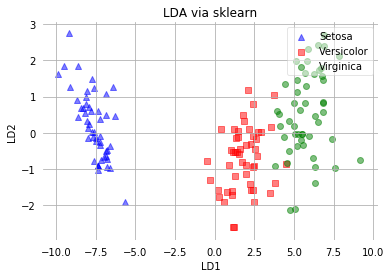

In [151]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components =2)
X_lda_sklearn = lda.fit_transform(X,y)

# 可视化
def plot_scikit_lda():
    
    ax = plt.subplot(111)
    for label, marker, color in zip(range(1,4),('^','s','o'),
                                   ('blue','red','green')):
        plt.scatter(X_lda_sklearn[:,0][y==label],
                   X_lda_sklearn[:,1][y==label],
                   marker = marker,
                   color = color,
                    alpha = 0.5,
                   label = label_dict[label])
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    
    leg = plt.legend(loc = 'upper right', fancybox = True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA via sklearn')
    
    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")
    
    #remove axis spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_scikit_lda()

### 2.2 手动实现多分类 LDA

### 步骤：
- Step 1: 计算 d-维均值向量

In [124]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [ 5.006  3.418  1.464  0.244]

Mean Vector class 2: [ 5.936  2.77   4.26   1.326]

Mean Vector class 3: [ 6.588  2.974  5.552  2.026]



- Step 2: 计算散布矩阵
> - 类内散布矩阵Sw

In [125]:
np.set_printoptions(precision = 4, suppress = True) 

m = X.shape[1]
S_W = np.zeros((m,m))

for i, mean in zip(range(1,4), mean_vectors):
    feature = X[y==i]
    mean = np.mat(mean).T
    S_W  +=  np.dot(feature.T - np.tile(mean, len(feature)),feature - np.tile(mean, len(feature)).T)
print('within-class scatter matrix :\n',S_W)

within-class scatter matrix :
 [[ 38.9562  13.683   24.614    5.6556]
 [ 13.683   17.035    8.12     4.9132]
 [ 24.614    8.12    27.22     6.2536]
 [  5.6556   4.9132   6.2536   6.1756]]


- 类间散布矩阵

In [127]:
S_B = np.zeros((m,m))
mean_all = np.mean(X,axis= 0)

for i, mean_i in zip(range(1,4),mean_vectors):
    m_i = len(X[y==i])
    mean_i = mean_i.reshape(m,1)
    mean_all = mean_all.reshape(m,1)
    S_B =  S_B + m_i *(mean_i - mean_all).dot((mean_i - mean_all).T)
    
print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[  63.2121  -19.534   165.1647   71.3631]
 [ -19.534    10.9776  -56.0552  -22.4924]
 [ 165.1647  -56.0552  436.6437  186.9081]
 [  71.3631  -22.4924  186.9081   80.6041]]


- Step 3: 求解矩阵$S_W^{-1}S_B$的广义奇异值问题

In [128]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec = eig_vecs[:,i].reshape(4,1)
    print('\nEigenvector {}:\n{}'.format(i+1, eigvec.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1:
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2:
[[-0.009 ]
 [-0.589 ]
 [ 0.2543]
 [-0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3:
[[-0.1997]
 [-0.2343]
 [-0.302 ]
 [ 0.8116]]
Eigenvalue 3: 4.62e-15

Eigenvector 4:
[[-0.1997]
 [-0.2343]
 [-0.302 ]
 [ 0.8116]]
Eigenvalue 4: 4.62e-15


### 检查-特征值和特征向量的计算-通过$Av=\lambda v$

In [129]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                        eig_vals[i]*eigv,
                                         decimal = 6, err_msg =' ',verbose = True)
print('ok')

ok


- Step 4: 选择线性判别子构造新的特征空间 
> - 将特征向量按照特征值的大小降序排列。线性代数告诉我们，矩阵乘法可以看作一种线性变换，而特征向量和特征值代表了变换后的方向以及该方向上的缩放比例，因此特征值越大，说明这个方向在变换中越显著，也就是信息量最大。因此我们需要抛弃的是特征值较小的方向，因此，我们只需要选取前Top-K个特征值对应的特征向量，就得到了映射矩阵W。

In [130]:
# make a list of (eigenvalue, eigenvector) tuples
eig_pair = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tupls from high to low
eig_pair = sorted(eig_pair , key = lambda k: k[0], reverse = True)  

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order: \n')
for i in eig_pair:
    print(i[0],i[1])

Eigenvalues in decreasing order: 

32.2719577997 [-0.2049+0.j -0.3871+0.j  0.5465+0.j  0.7138+0.j]
0.27756686384 [-0.0090+0.j -0.5890+0.j  0.2543+0.j -0.7670+0.j]
5.0228932243e-15 [-0.1997+0.335j  -0.2343-0.1479j -0.3020-0.1457j  0.8116+0.j    ]
5.0228932243e-15 [-0.1997-0.335j  -0.2343+0.1479j -0.3020+0.1457j  0.8116-0.j    ]


从上面的特征值可以看到有2个特征值非常接近0，一是代表了它们不包含信息量，而是因为浮点运算的精确度问题。  
在LDA中，如果有C类，线性判别式最多只有C-1个，因此对于之前3类的数据集，最多只有2个特征值。

In [131]:
# 我们通过特征值的比例来体现方差的分布：  
print('Variance explained: \n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pair):
    print('eigvalue{0:}:{1:.2%}'.format(i+1,(j[0]/eigv_sum).real))

Variance explained: 

eigvalue1:99.15%
eigvalue2:0.85%
eigvalue3:0.00%
eigvalue4:0.00%


In [132]:
# 选择K =2 个特征向量作为映射矩阵，这里选了前2个有信息的。  
W = np.hstack((eig_pair[0][1].reshape(4,1),eig_pair[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


- Step 5:将样本投影到新空间

In [133]:
## 通过LDA降维，将数据降维为2维特征
X_lda = X.dot(W)
assert X_lda.shape == (150,2), 'The matrix is not 150*2 dimensional.'

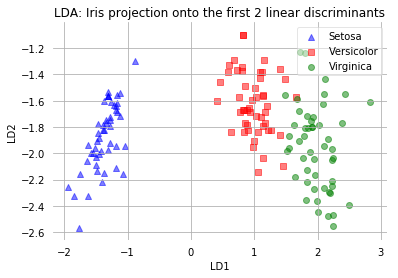

In [134]:
## 可视化
from matplotlib import pyplot as plt

def plot_step_lda():
    
    ax = plt.subplot(111)
    for label, marker, color in zip(range(1,4),('^','s','o'),
                                   ('blue','red','green')):
        plt.scatter(x=X_lda[:,0].real[y==label],
                   y=X_lda[:,1].real[y==label],
                   marker = marker,
                   color = color,
                   alpha = 0.5,
                   label = label_dict[label])
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    
    leg = plt.legend(loc = 'upper right', fancybox = True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')
    
    # hide axis ticks
    plt.tick_params(axis = 'both', which = 'both', bottom = 'off',
                   top = 'off',labelbottom = 'on', left = 'off',
                   right = 'off', labelleft= 'on')
    
    # remove axis spines 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_step_lda()

### 整理与总结

In [149]:
# 获得类均值
def mean_vec(features, labels):
    m = features.shape[0]
    mean_vecs = []
    for i in np.unique(labels):
        mean_vecs.append(np.mean(features[labels==i],axis=0))
    return mean_vecs
# 获得 类内散布矩阵
def within_scatter(features, labels):
    m = features.shape[1]
    S_w = np.zeros((m,m))
    mean_vectors = mean_vec(features, labels)
    for i, mean in zip(np.unique(labels),mean_vectors):
        m_i = len(features[labels==i])
        x = features[labels==i].T
        mean = np.mat(mean).T
        mean = np.tile(mean,m_i)
        S_w += (x-mean).dot((x-mean).T)
    return S_w
# 获得类间散布矩阵
def between_scatter(features,labels):
    m = features.shape[1]
    S_b = np.zeros((m,m))
    mean_all = np.mean(features, axis =0)
    mean_vector = mean_vec(features,labels)
    for i,mean in zip(np.unique(labels), mean_vector):
        m_i = len(features[labels==i])
        mean_all = mean_all.reshape(m,1)
        mean = mean.reshape(m,1)
        S_b += m_i*(mean-mean_all).dot((mean-mean_all).T)
    return S_b
# 获得投影矩阵
def get_components(features,labels,eig_vals,eig_vecs, n_comp = 2):
    m = features.shape[1]
    eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key = lambda x : x[0], reverse = True)
    
    W = np.hstack([eig_pairs[i][1].reshape(m,1) for i in range(0,n_comp)])
    return W

## main code
S_W = within_scatter(X,y)
S_B = between_scatter(X,y)
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
W1 = get_components(X,y,eig_vals, eig_vecs)

print('Eigvals :%s\n\nEigVecs:%s' % (eig_vals.real, eig_vecs.real))
print('\nW :%s'% W1.real)

Eigvals :[ 32.272    0.2776   0.       0.    ]

EigVecs:[[-0.2049 -0.009  -0.1997 -0.1997]
 [-0.3871 -0.589  -0.2343 -0.2343]
 [ 0.5465  0.2543 -0.302  -0.302 ]
 [ 0.7138 -0.767   0.8116  0.8116]]

W :[[-0.2049 -0.009 ]
 [-0.3871 -0.589 ]
 [ 0.5465  0.2543]
 [ 0.7138 -0.767 ]]


**注意**
数据标准化后的特征值不变，因此LDA在数据标准化后的特征值不变，特征向量进行一定的缩放，因此投影看起来是相同的。这里不做赘述。

### LDA和PCA的比较
LDA选择分类性能最好的投影方向，而PCA选择样本点投影具有最大方差的方向

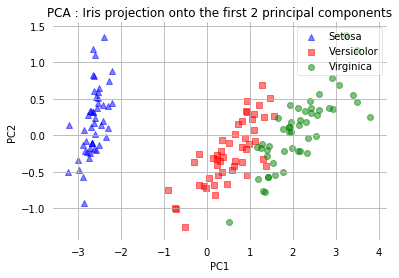

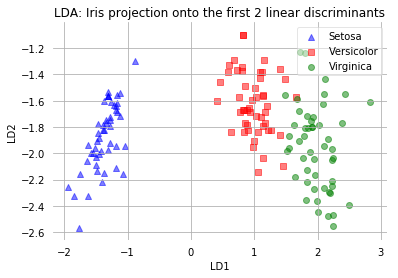

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

# 可视化
def plot_pca():
    
    ax = plt.subplot(111)
    
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_pca[:,0][y == label],
                y=X_pca[:,1][y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    
    leg = plt.legend(loc = 'upper right', fancybox = True)
    leg.get_frame().set_alpha(0.5)
    
    plt.title('PCA : Iris projection onto the first 2 principal components')
    
    # hide axis ticks
    plt.tick_params(axis = 'both', which = 'both', bottom = 'off',
                   top = 'off',labelbottom = 'on', left = 'off',
                   right = 'off', labelleft= 'on')
    # remove axis spines 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    
    plt.grid()
    plt.tight_layout
    plt.show()
    
plot_pca()
plot_step_lda()